In [ ]:
# Módulos
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import cv2
import glob
from matplotlib.backends.backend_pdf import PdfPages
import pickle

In [ ]:
# Importa o drive no Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Acessa o diretório principal dos dados
import os
os.chdir('/content/drive/My Drive/UFSM/DCG/Deep Learning/Transfer Learning e CNN (Classificação de doença por Raio-X)/data')

In [ ]:
# Seleciona as possíveis labels que eu desejo escolher do dataset 
LABELS = set(["Normal", "BacterialPneumonia", "COVID-19", "ViralPneumonia"])


In [ ]:
# Salva cada imagem e sua respectiva label 
image_list = []
labels = []
print('[INFO] Salvando imagens de BacterialPneumonia...')
for filename in glob.glob("BacterialPneumonia/*.jpeg"):
    im=cv2.imread(filename)
    image_list.append(im)
    labels.append('BacterialPneumonia')

print('[INFO] Salvando imagens de Normal...')    
for filename in glob.glob("Normal/*.jpeg"):
    im=cv2.imread(filename)
    image_list.append(im)
    labels.append('Normal')

print('[INFO] Salvando imagens de COVID-19...') 
for filename in glob.glob("COVID-19/*.jpeg"):
    im=cv2.imread(filename)
    image_list.append(im)
    labels.append('COVID-19')

print('[INFO] Salvando imagens de ViralPneumonia...') 
for filename in glob.glob("ViralPneumonia/*.jpeg"):
    im=cv2.imread(filename)
    image_list.append(im)
    labels.append('ViralPneumonia')

[INFO] Salvando imagens de BacterialPneumonia...
[INFO] Salvando imagens de Normal...
[INFO] Salvando imagens de COVID-19...
[INFO] Salvando imagens de ViralPneumonia...


In [ ]:
image_list = np.array(image_list)
labels = np.array(labels)

print(image_list.shape)
print(labels.shape)

(1762, 300, 400, 3)
(1762,)


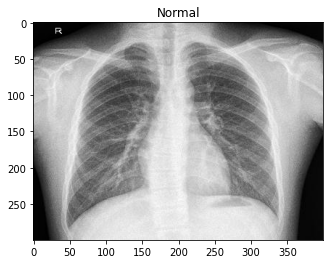

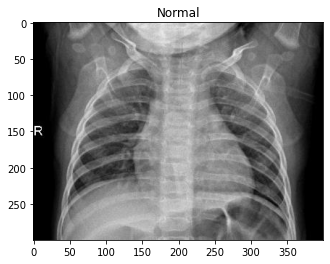

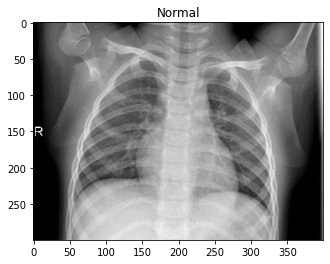

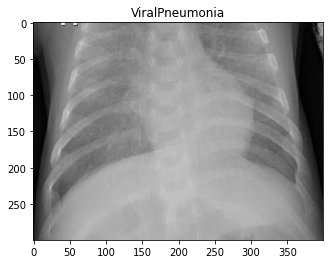

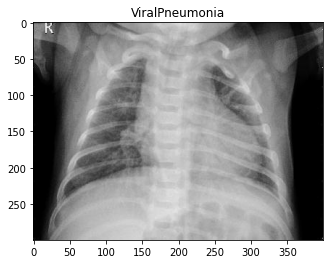

In [ ]:
# Visualização do dataset e labels
for i in range(0,5):
    k = np.random.randint(0,image_list.shape[0])
    plt.figure(i+1)
    plt.imshow(image_list[k,:,:,:])
    plt.title(labels[k])

In [ ]:
# One-hot Encoding
lb = LabelBinarizer()
labels_oh = lb.fit_transform(labels)

#Divide em treino e teste o dataset
x_train, x_test, y_train, y_test = train_test_split(image_list, labels_oh,test_size=0.30, stratify=labels, random_state=35)

In [ ]:
# Aumento de dados - permite uma maior generalização no modelo, transformando diversos vezes a imagem, de forma que a label ainda continue a mesma
# Diminui chance de overfitting tambem
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(
	                            rotation_range=15,
	                            fill_mode="nearest")



In [ ]:
# Modelo da rede DenseNet121 pré treinada 
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,input_tensor=tf.keras.Input(shape=(300, 400, 3)))
# Não atualiza os pesos
for layer in base_model.layers:
    layer.trainable = False
# Modelo da rede, atualizando as outras camadas, menos a da ResNet50
p = tf.keras.Sequential([
                         base_model,
                         tf.keras.layers.AveragePooling2D (pool_size=(7, 7)),
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(512, activation = 'relu'),
                         tf.keras.layers.Dropout(0.25),
                         tf.keras.layers.Dense(4, activation = 'softmax')
])

In [ ]:
# Visualização das layers
p.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 12, 512)        14714688  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [ ]:
# Compilador
p.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, decay = 0.001/30),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
h = p.fit(trainAug.flow(x_train, y_train, batch_size=32),
          steps_per_epoch=len(x_train) // 32,
          validation_data=(x_test, y_test),
          validation_steps=len(x_test) // 32,
          epochs=30)

Epoch 1/30
38/38 [==============================] - 33s 881ms/step - loss: 1.6774 - accuracy: 0.5079 - val_loss: 0.7336 - val_accuracy: 0.6824
Epoch 2/30
38/38 [==============================] - 31s 825ms/step - loss: 0.8351 - accuracy: 0.6361 - val_loss: 0.6402 - val_accuracy: 0.7221
Epoch 3/30
38/38 [==============================] - 32s 837ms/step - loss: 0.7175 - accuracy: 0.6761 - val_loss: 0.5506 - val_accuracy: 0.7486
Epoch 4/30
38/38 [==============================] - 31s 827ms/step - loss: 0.7005 - accuracy: 0.6886 - val_loss: 0.5764 - val_accuracy: 0.7561
Epoch 5/30
38/38 [==============================] - 32s 840ms/step - loss: 0.6285 - accuracy: 0.7236 - val_loss: 0.5049 - val_accuracy: 0.7732
Epoch 6/30
38/38 [==============================] - 32s 832ms/step - loss: 0.5663 - accuracy: 0.7369 - val_loss: 0.5065 - val_accuracy: 0.7656
Epoch 7/30
38/38 [==============================] - 32s 829ms/step - loss: 0.5654 - accuracy: 0.7460 - val_loss: 0.4992 - val_accuracy: 0.7921

In [ ]:
# Salva o modelo
p.save("/content/drive/My Drive/UFSM/DCG/Deep Learning/Transfer Learning e CNN (Classificação de doença por Raio-X)/output/model  ")

# Salva as labels
f = open("/content/drive/My Drive/UFSM/DCG/Deep Learning/Transfer Learning e CNN (Classificação de doença por Raio-X)/output/lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:

# Carrega o modelo pra não ficar treinando toda hora
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/UFSM/DCG/Deep Learning/Transfer Learning e CNN (Classificação de doença por Raio-X)/output/model')

lb = pickle.loads(open("/content/drive/My Drive/UFSM/DCG/Deep Learning/Transfer Learning e CNN (Classificação de doença por Raio-X)/output/lb.pickle", "rb").read())

# Traduz as labels
lb_pt = ['Pneumonia Bacteriana', 'Normal', 'COVID-19', 'Pneumonia Viral']



In [ ]:

# Plotamos o gráfico da evolução do erro
# no tempo. Esta é a chamada "curva de
# aprendizagem"
plt.figure(1)
plt.plot(h.history['loss'], label = 'Loss - train')
plt.plot(h.history['val_loss'], label = 'Loss - validation')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


plt.figure(2)
plt.plot(h.history['accuracy'], label = 'Accuracy - train')
plt.plot(h.history['val_accuracy'], label = 'Accuracy - validation')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
loss, accuracy = loaded_model.evaluate(x_train, y_train, verbose=0)

print('Taxa de acerto nos dados de treinamento:', \
      100*accuracy, '%')

loss, accuracy = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Taxa de acerto nos dados de validação:', \
      100*accuracy, '%')

Taxa de acerto nos dados de treinamento: 89.6999180316925 %
Taxa de acerto nos dados de validação: 80.34026622772217 %


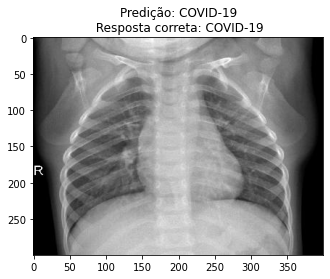

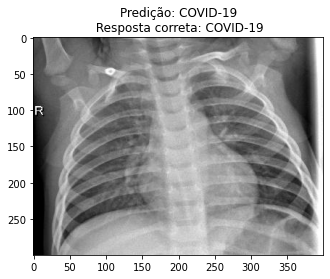

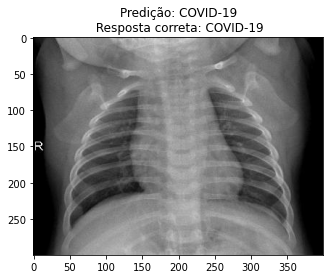

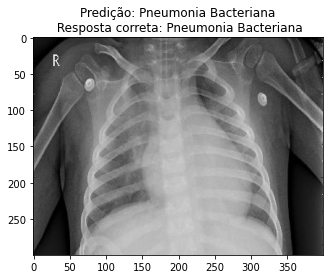

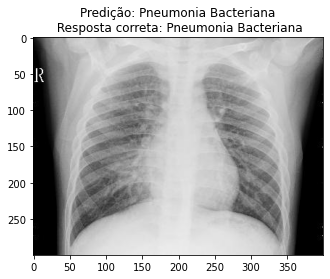

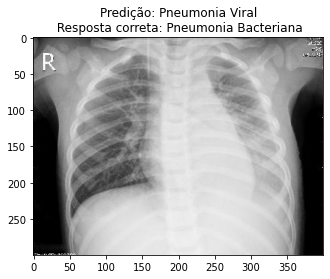

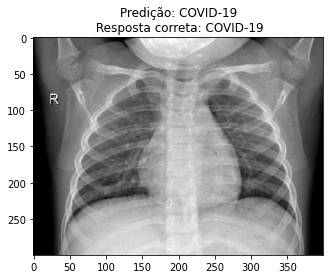

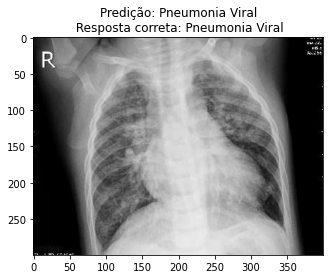

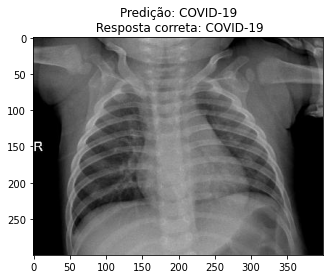

In [ ]:

# Mostra 10 predições aleatórias e o resultado certo
y_pred = loaded_model.predict(x_test, batch_size=32)

pp = PdfPages('/content/drive/My Drive/UFSM/DCG/Deep Learning/Transfer Learning e CNN (Classificação de doença por Raio-X)/output/relatorio.pdf')

for i in range(1,10):
  
    k = np.random.randint(x_test.shape[0])

    index_pred = np.argmax(y_pred[k,:])
    index_correto = np.argmax(y_test[k,:])

    pdf = PdfPages('test.pdf')

    plt.figure(i)
    plt.title ("Predição: "+ lb_pt[index_pred]  + "\n Resposta correta: " +  lb_pt[index_correto] )
    plt.imshow(x_test[k,:,:,:])
    pp.savefig(i)


pp.close()

In [ ]:
# Mostra a classificação e a precisão em cada classe
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),
	target_names=lb.classes_))

                    precision    recall  f1-score   support

BacterialPneumonia       0.75      0.78      0.77       195
          COVID-19       0.85      0.94      0.89        18
            Normal       0.97      0.96      0.97       192
    ViralPneumonia       0.61      0.56      0.59       124

          accuracy                           0.80       529
         macro avg       0.80      0.81      0.80       529
      weighted avg       0.80      0.80      0.80       529

